In [1]:
import os
import time
import datetime
import numpy as np
import warnings
import random
from PIL import Image
from tqdm import tqdm

from labels import labels

In [2]:
# 데이터 경로
#  os.getcwd() :'/home/ag/Capstone2/DeepLab_V3_ver1'
origin_data_path = os.getcwd() + '/data/Original_data/'
labeled_data_path = os.getcwd() + '/data/Labeled_data/'

origin_data_list = os.listdir(origin_data_path) # x
labeled_data_list = os.listdir(labeled_data_path) # y

# 파일명 랜덤
random.shuffle(origin_data_list)
random.shuffle(labeled_data_list)

# train, test / x, y 
train_x_file = origin_data_list[:int(len(origin_data_list)*0.8)]
train_y_file = [file_name[:-4] + '_L.png' for file_name in train_x_file]

test_x_file = [file_name for file_name in origin_data_list if file_name not in train_x_file]
test_y_file = [file_name[:-4] + '_L.png' for file_name in test_x_file]

In [3]:
print(len(train_x_file), len(test_x_file), len(train_y_file), len(test_y_file))

560 141 560 141


In [4]:
print(train_x_file[0], test_x_file[0], train_y_file[0], test_y_file[0])

Seq05VD_f02220.png 0016E5_08107.png Seq05VD_f02220_L.png 0016E5_08107_L.png


### X

In [5]:
train_x = [np.array(Image.open(origin_data_path + train)) for train in train_x_file]
test_x = [np.array(Image.open(origin_data_path + test)) for test in test_x_file]

### Y

In [6]:
# color to label catId
color2label = { label.color   : label.id for label in labels}

In [7]:
train_y = []
for file_name in tqdm(train_y_file):
    image = np.array(Image.open(labeled_data_path + file_name))
    ret = [[color2label[tuple([r[0], r[1], r[2]])] 
            if tuple([r[0], r[1], r[2]]) in color2label else 11
            for r in row] 
           for row in image]
    train_y.append(ret)

100%|██████████| 560/560 [21:43<00:00,  2.33s/it]


In [8]:
test_y = []
for file_name in tqdm(test_y_file):
    image = np.array(Image.open(labeled_data_path + file_name))
    ret = [[color2label[tuple([r[0], r[1], r[2]])] 
            if tuple([r[0], r[1], r[2]]) in color2label else 11
            for r in row] 
           for row in image]
    test_y.append(ret)

100%|██████████| 141/141 [05:28<00:00,  2.33s/it]


In [9]:
np.array(train_y).shape, np.array(test_y).shape

((560, 720, 960), (141, 720, 960))

In [10]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

### data save

In [11]:
np.savez('data.npz', train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y)

# Model

### package load

In [1]:
import os
import sys
import time
import datetime
from tqdm import tqdm
import numpy as np
import warnings
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms.functional as TF

In [2]:
from model import convert_bn_to_instancenorm, convert_bn_to_evonorm, convert_bn_to_groupnorm, DeepLabHead, UNet
from helpers import AverageMeter, ProgressMeter, iouCalc, visim, vislbl
from labels import labels

### CPU or GPU
#### 아래 코드에서 True이면 GPU 사용, False 이면 CPU 사용됨.

In [3]:
USE_CUDA = torch.cuda.is_available() and True 
device = torch.device('cuda' if USE_CUDA else 'cpu')

### data load

In [4]:
npzfile = np.load('data.npz')

train_x = npzfile['train_x']
train_y = npzfile['train_y']
test_x = npzfile['test_x']
test_y = npzfile['test_y']

npzfile.close()

### Cut Mix

In [5]:
def cutmix(image_x, image_y, size_x, size_y):
    w, h = image_x.shape[0], image_x.shape[1]
    
    # 복사할 이미지 랜덤 선택
    cxs, cys = random.randint(0, w-size_x), random.randint(0, h-size_y) # copy x start / copy y start
    cxe, cye = cxs + size_x, cys + size_y # copy x end / copy y end
    
    # 붙여넣을 위치
    xs, ys = random.randint(0, w-size_x), random.randint(0, h-size_y) 
    xe, ye = xs + size_x, ys + size_y
    
    result_x = image_x.copy()
    result_y = image_y.copy()
    result_x[xs:xe, ys:ye] = image_x[cxs:cxe, cys:cye]
    result_y[xs:xe, ys:ye] = image_y[cxs:cxe, cys:cye]
    
    return result_x, result_y

In [6]:
cutmix_index = list(range(len(train_x)))
np.random.shuffle(cutmix_index)

cutmix_num = 100
cutmix_index = cutmix_index[:cutmix_num]

append_x = []
append_y = []

for i in cutmix_index:
    app_x, app_y = cutmix(train_x[i], train_y[i], 200, 200)
    append_x.append(app_x)
    append_y.append(app_y)
    
train_x = np.append(train_x, append_x, axis=0)
train_y = np.append(train_y, append_y, axis=0)

### DeepLab v3 ResNet50 

In [7]:
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False).to(device)
model.classifier = DeepLabHead(2048, 12).to(device) # 12 = class num

In [8]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2) # 파라미터 학습속도 조절

In [9]:
# Initialize metrics
best_miou = 0.0
metrics = {'train_loss' : [],
           'train_acc' : [],
           'test_acc' : [],
           'test_loss' : [],
           'miou' : []}
start_epoch = 0

### Label 

In [10]:
# Create list of class names
classLabels = []
for label in labels:
    if label.name not in classLabels:
        classLabels.append(label.name)
classLabels.append('void')

In [11]:
validClasses = list(np.unique([label.id for label in labels if label.id >= 0] + [11]))

### train

In [12]:
train_X = torch.tensor(train_x, dtype=torch.float32)
train_Y = torch.tensor(train_y, dtype=torch.long)

train_data = torch.utils.data.TensorDataset(train_X.permute(dims=(0, 3, 1, 2)), train_Y)

train_data = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)

In [14]:
# class weight

dist = {i:(train_Y == i).sum().tolist() for i in range(12)}

weights = [1/dist[i] for i in range(12)]
total_weights = sum(weights)

class_weight = torch.FloatTensor([w/total_weights for w in weights]).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weight, ignore_index=12) # weight 파라미터에 class_weight 추가

num_epoch = 40
res = train_X.shape[1] * train_X.shape[2]

In [15]:
for epoch in range(num_epoch):

    loss_running = AverageMeter('Loss', ':.4e')
    acc_running = AverageMeter('Accuracy', ':.3f')  
    iou = iouCalc(classLabels, validClasses, voidClass = 11)
    progress = ProgressMeter(
        len(train_data),
        [loss_running, acc_running],
        prefix="Train, epoch: [{}]".format(epoch))
    
    for batch, (x, y) in enumerate(tqdm(train_data, total=len(train_data))):
        
        model.train()    
    
        x = x.to(device)
        y = y.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        outputs = model(x)
        outputs = outputs['out']
        preds = torch.argmax(outputs, 1)
        
        # cross-entropy loss
        loss = criterion(outputs, y)

        # backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        bs = x.size(0)
        loss = loss.item()
        loss_running.update(loss, bs)
        corrects = torch.sum((preds == y) & (y != 12))
        
        nvoid = int((y==12).sum())
        acc = corrects.double()/(bs*res-nvoid)
        acc_running.update(acc, bs)
        
        # Calculate IoU scores of current batch
        iou.evaluateBatch(preds, y)
        
        # progress.display(batch)
        
     
    scheduler.step(loss_running.avg)
    miou = iou.outputScores()
    
    print('train epoch ', epoch+1)
    print('loss : {:.4f}   acc : {:.4f}   miou : {:.4f}'.format(loss_running.avg, acc_running.avg, miou))
    
    # save checkpoint per epoch
    now = datetime.datetime.now()
    now_time = now.strftime('%y%m%d_%H:%M')
    
    # save path
    if not os.path.isdir(os.getcwd() + '/result'):
        os.makedirs(os.getcwd() + '/result')
    
    save_path = os.getcwd() + '/result/'
    
    with open(save_path + '05_resnet50_log_epoch.csv', 'a') as epoch_log:
            epoch_log.write('{}, {:.5f}, {:.5f}, {:.5f}\n'.format(
                    epoch+1, loss_running.avg, acc_running.avg, miou))
    
    # Save best model to file
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_miou': best_miou,
        'metrics': metrics,
        }, save_path + now_time + '_checkpoint.pth.tar')
    
    # Save best model to file
    if miou > best_miou:
        print('mIoU improved from {:.4f} to {:.4f}.'.format(best_miou, miou))
        best_miou = miou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            }, save_path + now_time + '_best_weights.pth.tar')


100%|██████████| 330/330 [05:29<00:00,  1.00it/s]


classes           IoU
---------------------
Pole          : 0.158
SignSymbol    : 0.246
Bicyclist     : 0.312
Pedestrian    : 0.222
Building      : 0.586
Fence         : 0.302
Pavement      : 0.607
Road          : 0.845
Car           : 0.627
Sky           : 0.808
Tree          : 0.646
---------------------
Mean IoU      : 0.487
---------------------
train epoch  1
loss : 0.8274   acc : 0.7677   miou : 0.4871
mIoU improved from 0.0000 to 0.4871.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.291
SignSymbol    : 0.459
Bicyclist     : 0.593
Pedestrian    : 0.496
Building      : 0.773
Fence         : 0.572
Pavement      : 0.754
Road          : 0.920
Car           : 0.815
Sky           : 0.883
Tree          : 0.766
---------------------
Mean IoU      : 0.666
---------------------
train epoch  2
loss : 0.4145   acc : 0.8713   miou : 0.6657
mIoU improved from 0.4871 to 0.6657.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.339
SignSymbol    : 0.541
Bicyclist     : 0.675
Pedestrian    : 0.562
Building      : 0.813
Fence         : 0.657
Pavement      : 0.794
Road          : 0.935
Car           : 0.850
Sky           : 0.893
Tree          : 0.789
---------------------
Mean IoU      : 0.713
---------------------
train epoch  3
loss : 0.3263   acc : 0.8922   miou : 0.7134
mIoU improved from 0.6657 to 0.7134.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.374
SignSymbol    : 0.600
Bicyclist     : 0.710
Pedestrian    : 0.593
Building      : 0.844
Fence         : 0.709
Pavement      : 0.822
Road          : 0.947
Car           : 0.871
Sky           : 0.901
Tree          : 0.812
---------------------
Mean IoU      : 0.744
---------------------
train epoch  4
loss : 0.2759   acc : 0.9078   miou : 0.7439
mIoU improved from 0.7134 to 0.7439.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.401
SignSymbol    : 0.633
Bicyclist     : 0.738
Pedestrian    : 0.625
Building      : 0.862
Fence         : 0.759
Pavement      : 0.843
Road          : 0.953
Car           : 0.886
Sky           : 0.905
Tree          : 0.826
---------------------
Mean IoU      : 0.766
---------------------
train epoch  5
loss : 0.2365   acc : 0.9175   miou : 0.7664
mIoU improved from 0.7439 to 0.7664.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.425
SignSymbol    : 0.661
Bicyclist     : 0.755
Pedestrian    : 0.644
Building      : 0.876
Fence         : 0.789
Pavement      : 0.858
Road          : 0.961
Car           : 0.895
Sky           : 0.909
Tree          : 0.840
---------------------
Mean IoU      : 0.783
---------------------
train epoch  6
loss : 0.2103   acc : 0.9256   miou : 0.7831
mIoU improved from 0.7664 to 0.7831.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.441
SignSymbol    : 0.675
Bicyclist     : 0.765
Pedestrian    : 0.658
Building      : 0.883
Fence         : 0.812
Pavement      : 0.869
Road          : 0.962
Car           : 0.899
Sky           : 0.911
Tree          : 0.847
---------------------
Mean IoU      : 0.793
---------------------
train epoch  7
loss : 0.1958   acc : 0.9292   miou : 0.7930
mIoU improved from 0.7831 to 0.7930.


100%|██████████| 330/330 [05:30<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.456
SignSymbol    : 0.702
Bicyclist     : 0.776
Pedestrian    : 0.670
Building      : 0.892
Fence         : 0.823
Pavement      : 0.878
Road          : 0.966
Car           : 0.904
Sky           : 0.914
Tree          : 0.852
---------------------
Mean IoU      : 0.803
---------------------
train epoch  8
loss : 0.1820   acc : 0.9342   miou : 0.8032
mIoU improved from 0.7930 to 0.8032.


100%|██████████| 330/330 [05:30<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.471
SignSymbol    : 0.719
Bicyclist     : 0.787
Pedestrian    : 0.682
Building      : 0.898
Fence         : 0.832
Pavement      : 0.884
Road          : 0.969
Car           : 0.908
Sky           : 0.916
Tree          : 0.860
---------------------
Mean IoU      : 0.811
---------------------
train epoch  9
loss : 0.1711   acc : 0.9373   miou : 0.8114
mIoU improved from 0.8032 to 0.8114.


100%|██████████| 330/330 [05:30<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.484
SignSymbol    : 0.732
Bicyclist     : 0.792
Pedestrian    : 0.692
Building      : 0.904
Fence         : 0.845
Pavement      : 0.891
Road          : 0.970
Car           : 0.913
Sky           : 0.918
Tree          : 0.867
---------------------
Mean IoU      : 0.819
---------------------
train epoch  10
loss : 0.1592   acc : 0.9407   miou : 0.8189
mIoU improved from 0.8114 to 0.8189.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.496
SignSymbol    : 0.740
Bicyclist     : 0.800
Pedestrian    : 0.702
Building      : 0.908
Fence         : 0.849
Pavement      : 0.894
Road          : 0.971
Car           : 0.916
Sky           : 0.920
Tree          : 0.871
---------------------
Mean IoU      : 0.824
---------------------
train epoch  11
loss : 0.1520   acc : 0.9428   miou : 0.8243
mIoU improved from 0.8189 to 0.8243.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.503
SignSymbol    : 0.748
Bicyclist     : 0.806
Pedestrian    : 0.708
Building      : 0.911
Fence         : 0.857
Pavement      : 0.896
Road          : 0.972
Car           : 0.918
Sky           : 0.921
Tree          : 0.874
---------------------
Mean IoU      : 0.828
---------------------
train epoch  12
loss : 0.1483   acc : 0.9442   miou : 0.8284
mIoU improved from 0.8243 to 0.8284.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.511
SignSymbol    : 0.757
Bicyclist     : 0.809
Pedestrian    : 0.715
Building      : 0.914
Fence         : 0.863
Pavement      : 0.902
Road          : 0.973
Car           : 0.920
Sky           : 0.922
Tree          : 0.878
---------------------
Mean IoU      : 0.833
---------------------
train epoch  13
loss : 0.1413   acc : 0.9461   miou : 0.8331
mIoU improved from 0.8284 to 0.8331.


100%|██████████| 330/330 [05:30<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.520
SignSymbol    : 0.764
Bicyclist     : 0.812
Pedestrian    : 0.721
Building      : 0.918
Fence         : 0.870
Pavement      : 0.904
Road          : 0.974
Car           : 0.922
Sky           : 0.923
Tree          : 0.881
---------------------
Mean IoU      : 0.837
---------------------
train epoch  14
loss : 0.1363   acc : 0.9477   miou : 0.8371
mIoU improved from 0.8331 to 0.8371.


100%|██████████| 330/330 [05:30<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.526
SignSymbol    : 0.770
Bicyclist     : 0.817
Pedestrian    : 0.728
Building      : 0.920
Fence         : 0.873
Pavement      : 0.906
Road          : 0.975
Car           : 0.924
Sky           : 0.923
Tree          : 0.884
---------------------
Mean IoU      : 0.841
---------------------
train epoch  15
loss : 0.1325   acc : 0.9490   miou : 0.8406
mIoU improved from 0.8371 to 0.8406.


100%|██████████| 330/330 [05:30<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.531
SignSymbol    : 0.773
Bicyclist     : 0.820
Pedestrian    : 0.731
Building      : 0.922
Fence         : 0.873
Pavement      : 0.908
Road          : 0.975
Car           : 0.926
Sky           : 0.924
Tree          : 0.885
---------------------
Mean IoU      : 0.843
---------------------
train epoch  16
loss : 0.1302   acc : 0.9497   miou : 0.8425
mIoU improved from 0.8406 to 0.8425.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.541
SignSymbol    : 0.781
Bicyclist     : 0.825
Pedestrian    : 0.735
Building      : 0.924
Fence         : 0.880
Pavement      : 0.911
Road          : 0.976
Car           : 0.928
Sky           : 0.925
Tree          : 0.889
---------------------
Mean IoU      : 0.847
---------------------
train epoch  17
loss : 0.1255   acc : 0.9512   miou : 0.8468
mIoU improved from 0.8425 to 0.8468.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.543
SignSymbol    : 0.786
Bicyclist     : 0.826
Pedestrian    : 0.740
Building      : 0.926
Fence         : 0.885
Pavement      : 0.913
Road          : 0.976
Car           : 0.929
Sky           : 0.926
Tree          : 0.891
---------------------
Mean IoU      : 0.849
---------------------
train epoch  18
loss : 0.1225   acc : 0.9521   miou : 0.8491


  0%|          | 0/330 [00:00<?, ?it/s]

mIoU improved from 0.8468 to 0.8491.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.549
SignSymbol    : 0.790
Bicyclist     : 0.829
Pedestrian    : 0.744
Building      : 0.927
Fence         : 0.888
Pavement      : 0.914
Road          : 0.976
Car           : 0.930
Sky           : 0.927
Tree          : 0.892
---------------------
Mean IoU      : 0.852
---------------------
train epoch  19
loss : 0.1194   acc : 0.9528   miou : 0.8515
mIoU improved from 0.8491 to 0.8515.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.553
SignSymbol    : 0.794
Bicyclist     : 0.833
Pedestrian    : 0.748
Building      : 0.929
Fence         : 0.889
Pavement      : 0.917
Road          : 0.977
Car           : 0.931
Sky           : 0.927
Tree          : 0.894
---------------------
Mean IoU      : 0.854
---------------------
train epoch  20
loss : 0.1176   acc : 0.9537   miou : 0.8539
mIoU improved from 0.8515 to 0.8539.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.560
SignSymbol    : 0.799
Bicyclist     : 0.833
Pedestrian    : 0.750
Building      : 0.931
Fence         : 0.892
Pavement      : 0.918
Road          : 0.977
Car           : 0.933
Sky           : 0.927
Tree          : 0.895
---------------------
Mean IoU      : 0.856
---------------------
train epoch  21
loss : 0.1147   acc : 0.9543   miou : 0.8559


  0%|          | 0/330 [00:00<?, ?it/s]

mIoU improved from 0.8539 to 0.8559.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.562
SignSymbol    : 0.801
Bicyclist     : 0.837
Pedestrian    : 0.756
Building      : 0.932
Fence         : 0.896
Pavement      : 0.919
Road          : 0.978
Car           : 0.933
Sky           : 0.928
Tree          : 0.898
---------------------
Mean IoU      : 0.858
---------------------
train epoch  22
loss : 0.1127   acc : 0.9552   miou : 0.8582
mIoU improved from 0.8559 to 0.8582.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.565
SignSymbol    : 0.804
Bicyclist     : 0.838
Pedestrian    : 0.758
Building      : 0.933
Fence         : 0.894
Pavement      : 0.921
Road          : 0.978
Car           : 0.934
Sky           : 0.929
Tree          : 0.899
---------------------
Mean IoU      : 0.859
---------------------
train epoch  23
loss : 0.1111   acc : 0.9559   miou : 0.8595
mIoU improved from 0.8582 to 0.8595.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.569
SignSymbol    : 0.807
Bicyclist     : 0.840
Pedestrian    : 0.761
Building      : 0.934
Fence         : 0.898
Pavement      : 0.923
Road          : 0.978
Car           : 0.936
Sky           : 0.930
Tree          : 0.901
---------------------
Mean IoU      : 0.861
---------------------
train epoch  24
loss : 0.1087   acc : 0.9566   miou : 0.8615
mIoU improved from 0.8595 to 0.8615.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.574
SignSymbol    : 0.812
Bicyclist     : 0.842
Pedestrian    : 0.765
Building      : 0.936
Fence         : 0.901
Pavement      : 0.923
Road          : 0.979
Car           : 0.937
Sky           : 0.930
Tree          : 0.903
---------------------
Mean IoU      : 0.864
---------------------
train epoch  25
loss : 0.1068   acc : 0.9572   miou : 0.8636
mIoU improved from 0.8615 to 0.8636.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.578
SignSymbol    : 0.814
Bicyclist     : 0.842
Pedestrian    : 0.765
Building      : 0.936
Fence         : 0.904
Pavement      : 0.925
Road          : 0.979
Car           : 0.937
Sky           : 0.931
Tree          : 0.903
---------------------
Mean IoU      : 0.865
---------------------
train epoch  26
loss : 0.1051   acc : 0.9577   miou : 0.8649
mIoU improved from 0.8636 to 0.8649.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.581
SignSymbol    : 0.818
Bicyclist     : 0.846
Pedestrian    : 0.768
Building      : 0.938
Fence         : 0.904
Pavement      : 0.926
Road          : 0.979
Car           : 0.938
Sky           : 0.931
Tree          : 0.905
---------------------
Mean IoU      : 0.867
---------------------
train epoch  27
loss : 0.1036   acc : 0.9584   miou : 0.8668
mIoU improved from 0.8649 to 0.8668.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.583
SignSymbol    : 0.819
Bicyclist     : 0.847
Pedestrian    : 0.770
Building      : 0.939
Fence         : 0.905
Pavement      : 0.927
Road          : 0.979
Car           : 0.940
Sky           : 0.931
Tree          : 0.906
---------------------
Mean IoU      : 0.868
---------------------
train epoch  28
loss : 0.1023   acc : 0.9587   miou : 0.8679
mIoU improved from 0.8668 to 0.8679.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.585
SignSymbol    : 0.822
Bicyclist     : 0.848
Pedestrian    : 0.772
Building      : 0.939
Fence         : 0.908
Pavement      : 0.928
Road          : 0.980
Car           : 0.940
Sky           : 0.932
Tree          : 0.906
---------------------
Mean IoU      : 0.869
---------------------
train epoch  29
loss : 0.1010   acc : 0.9592   miou : 0.8691
mIoU improved from 0.8679 to 0.8691.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.589
SignSymbol    : 0.825
Bicyclist     : 0.851
Pedestrian    : 0.774
Building      : 0.940
Fence         : 0.907
Pavement      : 0.929
Road          : 0.980
Car           : 0.940
Sky           : 0.931
Tree          : 0.908
---------------------
Mean IoU      : 0.870
---------------------
train epoch  30
loss : 0.0998   acc : 0.9595   miou : 0.8704
mIoU improved from 0.8691 to 0.8704.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.592
SignSymbol    : 0.827
Bicyclist     : 0.853
Pedestrian    : 0.775
Building      : 0.941
Fence         : 0.909
Pavement      : 0.930
Road          : 0.980
Car           : 0.942
Sky           : 0.932
Tree          : 0.909
---------------------
Mean IoU      : 0.872
---------------------
train epoch  31
loss : 0.0987   acc : 0.9602   miou : 0.8718
mIoU improved from 0.8704 to 0.8718.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.593
SignSymbol    : 0.828
Bicyclist     : 0.853
Pedestrian    : 0.778
Building      : 0.942
Fence         : 0.910
Pavement      : 0.931
Road          : 0.980
Car           : 0.942
Sky           : 0.932
Tree          : 0.911
---------------------
Mean IoU      : 0.873
---------------------
train epoch  32
loss : 0.0967   acc : 0.9606   miou : 0.8728
mIoU improved from 0.8718 to 0.8728.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.596
SignSymbol    : 0.831
Bicyclist     : 0.855
Pedestrian    : 0.781
Building      : 0.943
Fence         : 0.912
Pavement      : 0.931
Road          : 0.981
Car           : 0.943
Sky           : 0.933
Tree          : 0.911
---------------------
Mean IoU      : 0.874
---------------------
train epoch  33
loss : 0.0958   acc : 0.9609   miou : 0.8744
mIoU improved from 0.8728 to 0.8744.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.599
SignSymbol    : 0.832
Bicyclist     : 0.856
Pedestrian    : 0.781
Building      : 0.943
Fence         : 0.914
Pavement      : 0.932
Road          : 0.981
Car           : 0.943
Sky           : 0.933
Tree          : 0.911
---------------------
Mean IoU      : 0.875
---------------------
train epoch  34
loss : 0.0953   acc : 0.9611   miou : 0.8750
mIoU improved from 0.8744 to 0.8750.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.602
SignSymbol    : 0.835
Bicyclist     : 0.857
Pedestrian    : 0.785
Building      : 0.944
Fence         : 0.915
Pavement      : 0.932
Road          : 0.981
Car           : 0.944
Sky           : 0.933
Tree          : 0.912
---------------------
Mean IoU      : 0.876
---------------------
train epoch  35
loss : 0.0937   acc : 0.9616   miou : 0.8765
mIoU improved from 0.8750 to 0.8765.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.604
SignSymbol    : 0.836
Bicyclist     : 0.859
Pedestrian    : 0.785
Building      : 0.944
Fence         : 0.917
Pavement      : 0.934
Road          : 0.981
Car           : 0.945
Sky           : 0.933
Tree          : 0.914
---------------------
Mean IoU      : 0.878
---------------------
train epoch  36
loss : 0.0922   acc : 0.9621   miou : 0.8776
mIoU improved from 0.8765 to 0.8776.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.607
SignSymbol    : 0.839
Bicyclist     : 0.859
Pedestrian    : 0.787
Building      : 0.945
Fence         : 0.917
Pavement      : 0.934
Road          : 0.981
Car           : 0.945
Sky           : 0.934
Tree          : 0.914
---------------------
Mean IoU      : 0.878
---------------------
train epoch  37
loss : 0.0918   acc : 0.9624   miou : 0.8785
mIoU improved from 0.8776 to 0.8785.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.609
SignSymbol    : 0.841
Bicyclist     : 0.860
Pedestrian    : 0.790
Building      : 0.946
Fence         : 0.918
Pavement      : 0.935
Road          : 0.982
Car           : 0.946
Sky           : 0.934
Tree          : 0.915
---------------------
Mean IoU      : 0.880
---------------------
train epoch  38
loss : 0.0901   acc : 0.9627   miou : 0.8796
mIoU improved from 0.8785 to 0.8796.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.611
SignSymbol    : 0.842
Bicyclist     : 0.861
Pedestrian    : 0.790
Building      : 0.947
Fence         : 0.921
Pavement      : 0.936
Road          : 0.982
Car           : 0.946
Sky           : 0.935
Tree          : 0.917
---------------------
Mean IoU      : 0.881
---------------------
train epoch  39
loss : 0.0895   acc : 0.9632   miou : 0.8807
mIoU improved from 0.8796 to 0.8807.


100%|██████████| 330/330 [05:31<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.613
SignSymbol    : 0.844
Bicyclist     : 0.863
Pedestrian    : 0.792
Building      : 0.947
Fence         : 0.921
Pavement      : 0.937
Road          : 0.982
Car           : 0.947
Sky           : 0.934
Tree          : 0.917
---------------------
Mean IoU      : 0.881
---------------------
train epoch  40
loss : 0.0885   acc : 0.9633   miou : 0.8814
mIoU improved from 0.8807 to 0.8814.


### test

In [28]:
X = torch.tensor(test_x, dtype=torch.float32)
Y = torch.tensor(test_y, dtype=torch.long)

data = torch.utils.data.TensorDataset(X.permute(dims=(0, 3, 1, 2)), Y)

test_data = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)

In [29]:
# Load best model

# save path
if not os.path.isdir(os.getcwd() + '/result'):
    os.makedirs(os.getcwd() + '/result')

save_path = os.getcwd() + '/result/'
result = sorted(os.listdir(save_path), reverse=True)

In [30]:
checkpoint = torch.load(save_path + result[1]) # 가장 최신 best_weights 파일 가져옴
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
print('Loaded best model weights (epoch {}) from {}'.format(checkpoint['epoch'], save_path + result[1]))

Loaded best model weights (epoch 39) from /home/ag/Capstone2/TEST/result/210604_20:56_best_weights.pth.tar


In [31]:
batch_time = AverageMeter('Time', ':6.3f')
data_time = AverageMeter('Data', ':6.3f')
loss_running = AverageMeter('Loss', ':.4e')
acc_running = AverageMeter('Accuracy', ':.3f')  
iou = iouCalc(classLabels, validClasses, voidClass = 11)
progress = ProgressMeter(
    len(test_data),
    [batch_time, data_time],
    prefix='Predict: ')

model.eval()

batch_loss = 0.0
for batch, (x, y) in enumerate(tqdm(test_data, total=len(test_data))):

    x = x.to(device)
    y = y.to(device)

    # forward
    outputs = model(x)
    outputs = outputs['out']

    preds = torch.argmax(outputs, 1)

    # cross-entropy loss
    loss = criterion(outputs, y)

    # Statistics
    bs = x.size(0)
    loss = loss.item()
    loss_running.update(loss, bs)
    corrects = torch.sum((preds == y) & (y != 12))

    nvoid = int((y==12).sum())
    acc = corrects.double()/(bs*res-nvoid)
    acc_running.update(acc, bs)

    # Calculate IoU scores of current batch
    iou.evaluateBatch(preds, y)

miou = iou.outputScores()
scheduler.step(loss_running.avg)

print('loss : {:.4f} acc : {:.4f} miou : {:.4f}'.format(loss_running.avg, acc_running.avg, miou))

100%|██████████| 141/141 [00:14<00:00,  9.43it/s]

classes           IoU
---------------------
Pole          : 0.492
SignSymbol    : 0.657
Bicyclist     : 0.799
Pedestrian    : 0.696
Building      : 0.918
Fence         : 0.772
Pavement      : 0.865
Road          : 0.971
Car           : 0.902
Sky           : 0.929
Tree          : 0.848
---------------------
Mean IoU      : 0.804
---------------------
loss : 0.4920 acc : 0.9365 miou : 0.8043


### visualization

In [22]:
import pandas as pd
log_epoch = pd.read_csv('result/05_resnet50_log_epoch.csv',
                       names = ['epoch', 'loss', 'accuracy', 'miou'])

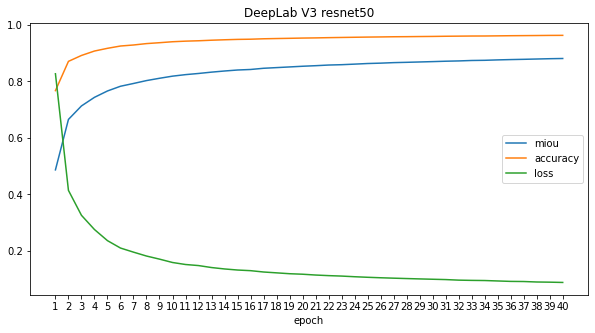

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(log_epoch['epoch'], log_epoch['miou'], label = 'miou')
plt.plot(log_epoch['epoch'], log_epoch['accuracy'], label = 'accuracy')
plt.plot(log_epoch['epoch'], log_epoch['loss'], label = 'loss')
plt.xticks([i for i in range(1, log_epoch.shape[0]+1)])
plt.title("DeepLab V3 resnet50")
plt.xlabel("epoch")
plt.ylabel("")
plt.legend()
plt.show()

In [33]:
train_X = torch.tensor(train_x[:int(train_x.shape[0]*0.875)], dtype=torch.float32)
train_Y = torch.tensor(train_y[:int(train_y.shape[0]*0.875)], dtype=torch.long)

train_data = torch.utils.data.TensorDataset(train_X.permute(dims=(0, 3, 1, 2)), train_Y)

train_data = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)

In [ ]:
val_X = torch.tensor(train_x[int(train_x.shape[0]*0.875):], dtype=torch.float32)
val_Y = torch.tensor(train_y[int(train_x.shape[0]*0.875):], dtype=torch.long)

val_data = torch.utils.data.TensorDataset(val_X.permute(dims=(0, 3, 1, 2)), val_Y)

val_data = torch.utils.data.DataLoader(val_data, batch_size=2, shuffle=False)

In [ ]:
# validataion
model.eval()

loss_running = AverageMeter('Loss', ':.4e')
acc_running = AverageMeter('Accuracy', ':.3f')
iou = iouCalc(classLabels, validClasses, voidClass = 11)

batch_loss = 0.0
for batch, (x, y) in enumerate(tqdm(val_data, total=len(val_data))):

    x = x.to(device)
    y = y.to(device)

    # forward
    outputs = model(x)
    outputs = outputs['out']

    preds = torch.argmax(outputs, 1)

    # cross-entropy loss
    loss = criterion(outputs, y)

    # Statistics
    bs = x.size(0)
    loss = loss.item()
    loss_running.update(loss, bs)
    corrects = torch.sum((preds == y) & (y != 12))

    nvoid = int((y==12).sum())
    acc = corrects.double()/(bs*res-nvoid)
    acc_running.update(acc, bs)

    # Calculate IoU scores of current batch
    iou.evaluateBatch(preds, y)

miou = iou.outputScores()

# Reduce learning rate
scheduler.step(loss_running.avg) 

print('validataion')
print('loss : {:.4f}   acc : {:.4f}   miou : {:.4f}'.format(loss_running.avg, acc_running.avg, miou))